Explores the explainability of the fine-tuned ResNet50 model using SHapley Additive exPlanations (SHAP):
- Identifying key spatial features of Alzheimer's progression
- Investigating misclassifications and performing cluster analyses
- Validating model focus and reliability through SHAP visualizations

In [0]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
from tensorflow.keras.utils import to_categorical
import shap

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
from IPython.display import clear_output

# src
import sys
sys.path.append('/Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/src')
from visualize import visualize_training
from custom_pruning import global_prune_model
from data_io import save_model_s3, load_model_s3, save_pickle_s3, load_pickle_s3

clear_output(wait=False)

Mount AWS S3 bucket containing processed data

In [0]:
ACCESS_KEY = dbutils.secrets.get(scope="brad-aws", key="access_key")
SECRET_KEY= dbutils.secrets.get(scope="brad-aws", key="secret_key")

# specify bucket and mount point
AWS_S3_BUCKET = "databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/raw/"
MOUNT_NAME = f"/mnt/{AWS_S3_BUCKET.split('/')[-2]}"
SOURCE_URL = f"s3a://{AWS_S3_BUCKET}"
EXTRA_CONFIGS = { "fs.s3a.access.key": ACCESS_KEY, "fs.s3a.secret.key": SECRET_KEY}

# mount bucket
if any(mount.mountPoint == MOUNT_NAME for mount in dbutils.fs.mounts()):
    print(f"{MOUNT_NAME} is already mounted.")
else:
    dbutils.fs.mount(SOURCE_URL, MOUNT_NAME, extra_configs = EXTRA_CONFIGS)
    print(f"{MOUNT_NAME} is now mounted.")

/mnt/raw is already mounted.


In [0]:
# Load data file and unpack contents
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/preprocessed/data_preprocessed.pkl'
data=load_pickle_s3(bucket_name, s3_file_name, dbutils)

train_data=data['train_data']
train_lab=data['train_labels']
test_data=data['test_data']
test_lab=data['test_labels']
    
# Convert labels to categorical
train_lab_cat = to_categorical(train_lab.astype('int8'), num_classes=4)
test_lab_cat = to_categorical(test_lab.astype('int8'), num_classes=4)

It is paramount to explain the image-based features that contribute to classification. In the current context, since the dataset is comprised of registered anatomical MRI, feature importance can implicate certain brain regions in AD disease progression. To do this, we first compute and average SHAP values across the entire dataset to understand the most influential features (pixels).

In [0]:
# Load fine-tuned model
bucket_name = "databricks-workspace-stack-brad-personal-bucket"
s3_file_path = 'AD_MRI_classification/results/model_resnet50_fine_tune.h5'
pre_pruned_model = load_model_s3(bucket_name, s3_file_path, dbutils)

# Initialize SHAP explainer
shap_data = train_data.reshape((train_data.shape[0], 128, 128, 1))
explainer = shap.GradientExplainer(pre_pruned_model, shap_data)

# Sample all classes equally (and randomly)
unique_classes, class_counts = np.unique(train_lab, return_counts=True)
min_count = np.min(class_counts)
min_count = 1

random_indices_class = []
for i in unique_classes:
    indices_class_tot = np.where(train_lab == i)[0]
    indices_class_rand = np.random.choice(indices_class_tot, min_count, replace=False)
    random_indices_class = np.concatenate([random_indices_class, indices_class_rand], axis=0)
random_indices_class = random_indices_class.astype(int)

# Compute SHAP values
shap_values_all = explainer.shap_values(shap_data[random_indices_class,:,:,:])
clear_output(wait=False)

2025-01-16 19:42:36.131172: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/databricks/python/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer_1. Received: the structure of inputs=['*']
  warnings.warn(
2025-01-16 19:42:40.773595: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 52428800 exceeds 10% of free system memory.
2025-01-16 19:42:40.924729: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55756800 exceeds 10% of free system memory.
2025-01-16 19:42:41.109175: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 52428800 exceeds 10% of free system memory.
2025-01-16 19:42:41.860353: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 52428800 exceeds 10% of f

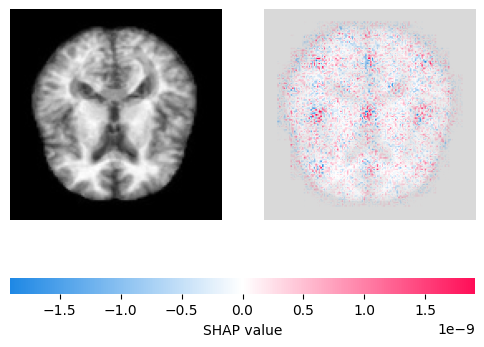

In [0]:
mean_shap = np.mean(np.mean(shap_values_all, axis=0), axis=3)

# Plot on average image
shap_data_mean = np.mean(shap_data[random_indices_class,:,:,:], axis=0)
# shap_data_mean = shap_data_mean.reshape(1, 128, 128, 1)

# Visualize SHAP values
clear_output(wait=False)
shap.image_plot(mean_shap, shap_data_mean) 

As there are four classes within this dataset, we can also visualize the SHAP values for each stage of AD individually

/databricks/python/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer_1. Received: the structure of inputs=['*']
  warnings.warn(


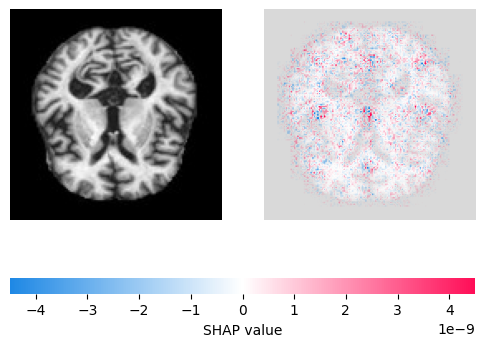

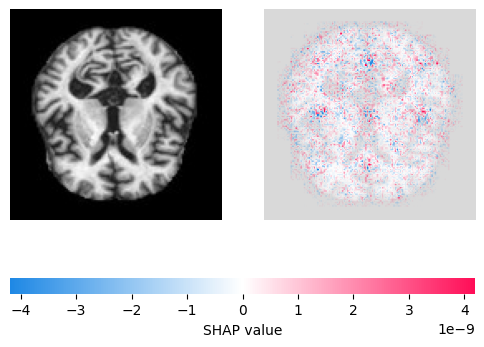

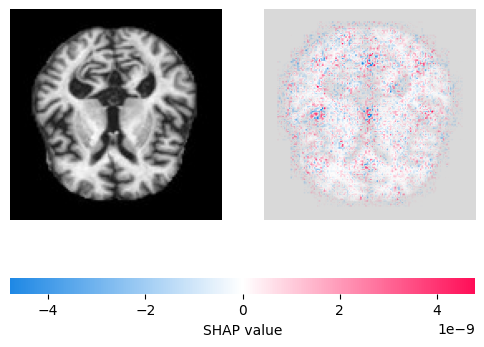

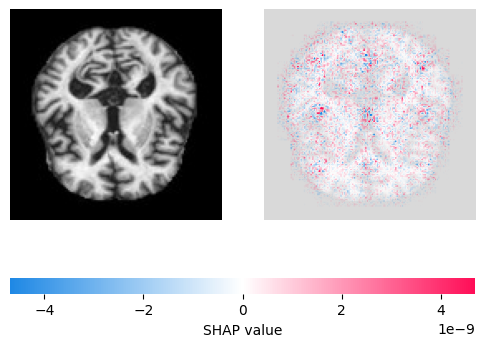

<Figure size 640x480 with 0 Axes>

In [0]:
for i in unique_classes:

    current_idx = np.where(train_lab[random_indices_class] == 1)[0]
    current_idx = random_indices_class[current_idx]
    print(current_idx)

    shap_values_class = explainer.shap_values(shap_data[current_idx,:,:,:])
    mean_shap_class = np.mean(shap_values_class, axis=4)
    mean_shap_class = mean_shap_class.reshape(128, 128, 1)

    # # Plot on average image
    # shap_data_mean = np.mean(shap_data[current_idx,:,:,:], axis=0)
    # shap_data_mean = shap_data_mean.reshape(128, 128, 1)

    # # Visualize SHAP values
    # shap.image_plot(mean_shap_class, shap_data_mean)

plt.tight_layout()
plt.show()

For incorrectly classified samples, visualize SHAP values to identify patterns in feature misinterpretation.

In [0]:
misclassified = np.where(predictions != test_labels)[0]
for idx in misclassified[:5]:
    shap_values = explainer.shap_values(test_data2[idx:idx+1])
    shap.image_plot(shap_values, test_data2[idx:idx+1])


Cluster: Group similar samples based on their SHAP value patterns to identify clusters in the decision-making process.

In [0]:
shap.summary_plot(shap_values_all, test_data2, plot_type="bar")